In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy.fft import fft, fftfreq


In [14]:
def twiddle_mat(N: int) -> np.ndarray:
    """Generate the DFT twiddle factor matrix."""
    if N <= 0:
        raise ValueError('FFT size must be greater than zero.')
    W = np.zeros((N, N), dtype=np.complex64)
    for n in range(N):
        for k in range(N):
            W[n, k] = np.exp(-2j * np.pi * k * n / N)
    return W

# Generate twiddle factor matrix
N = 1024
W = twiddle_mat(N)


In [15]:
fs = 1000  # Sampling frequency
t = np.linspace(0, 4, 4 * fs, endpoint=False)  # 4 seconds duration

# Create signal with multiple frequencies
signal = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 100 * t) + np.sin(2 * np.pi * 250 * t)

# Truncate signal to N=4096 samples
signal = signal[:N]


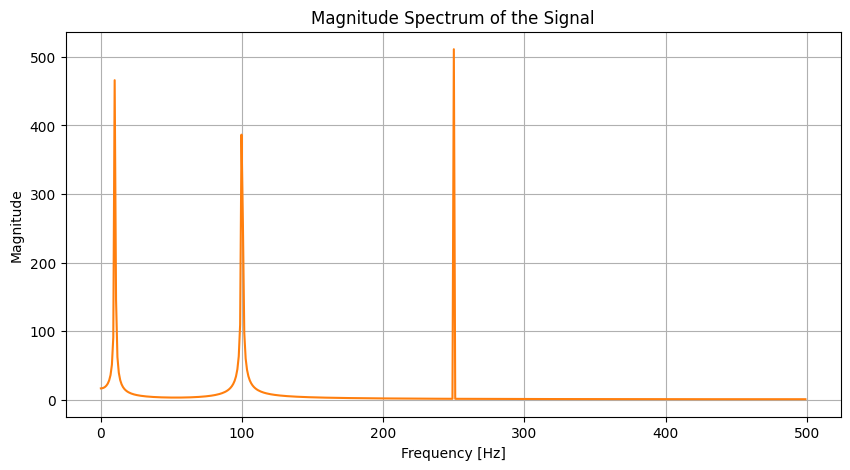

In [16]:
# Compute DFT using matrix multiplication
X_dft = W @ signal

# Compute magnitude spectrum
magnitude = np.abs(X_dft)
frequencies = np.fft.fftfreq(N, 1/fs)

# Plot magnitude spectrum
plt.figure(figsize=(10, 5))
plt.plot(frequencies[:N//2], magnitude[:N//2], color='C1')
plt.title("Magnitude Spectrum of the Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.show()


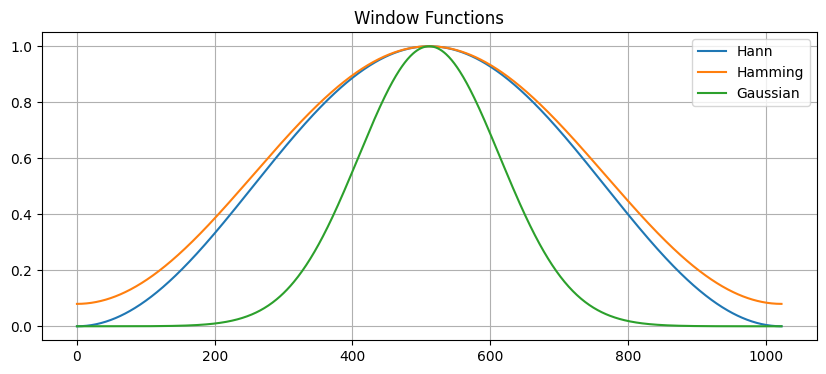

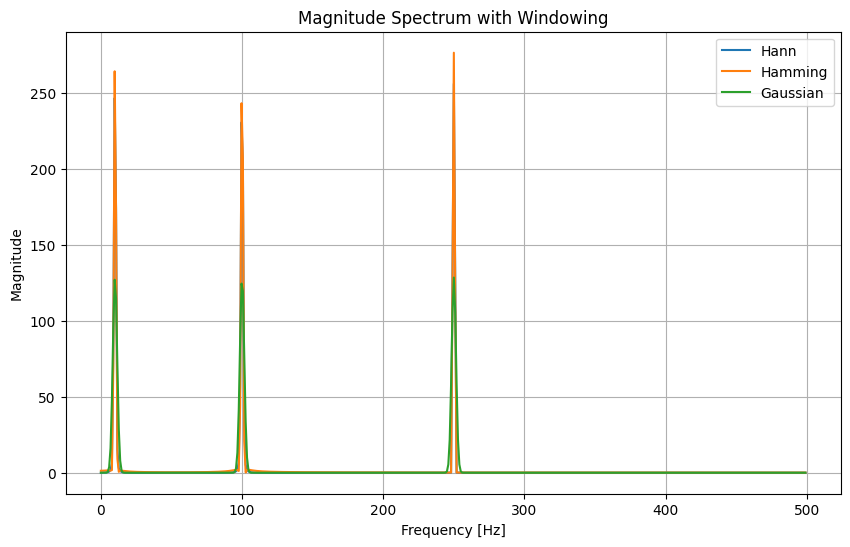

In [17]:
from scipy.signal.windows import hann, hamming, gaussian

# Generate window functions
hann_window = hann(N)
hamming_window = hamming(N)
gaussian_window = gaussian(N, std=N/10)

# Apply windows to signal
signal_hann = signal * hann_window
signal_hamming = signal * hamming_window
signal_gaussian = signal * gaussian_window

# Compute DFT with windowing
X_hann = W @ signal_hann
X_hamming = W @ signal_hamming
X_gaussian = W @ signal_gaussian

# Compute magnitude spectra
magnitude_hann = np.abs(X_hann)
magnitude_hamming = np.abs(X_hamming)
magnitude_gaussian = np.abs(X_gaussian)

# Plot window functions
plt.figure(figsize=(10, 4))
plt.plot(hann_window, label="Hann", color='C0')
plt.plot(hamming_window, label="Hamming", color='C1')
plt.plot(gaussian_window, label="Gaussian", color='C2')
plt.title("Window Functions")
plt.legend()
plt.grid()
plt.show()

# Plot magnitude spectra with windows
plt.figure(figsize=(10, 6))
plt.plot(frequencies[:N//2], magnitude_hann[:N//2], label="Hann", color='C0')
plt.plot(frequencies[:N//2], magnitude_hamming[:N//2], label="Hamming", color='C1')
plt.plot(frequencies[:N//2], magnitude_gaussian[:N//2], label="Gaussian", color='C2')
plt.title("Magnitude Spectrum with Windowing")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()


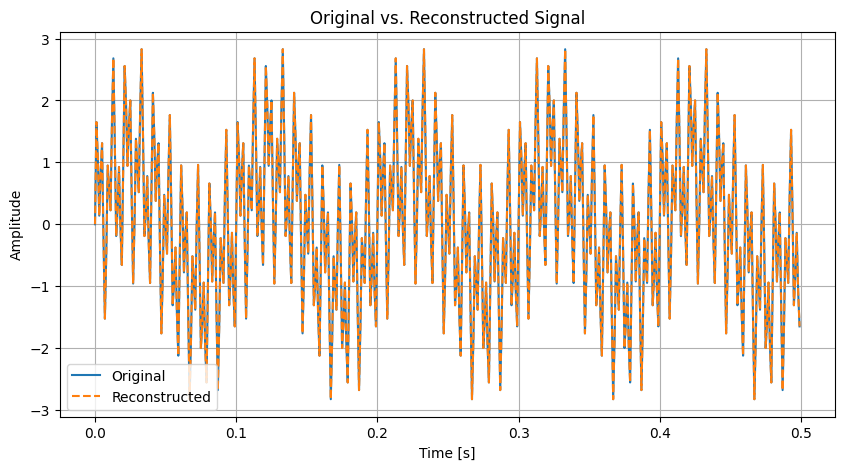

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

# Parameters
fs = 1000  # Sampling frequency
T = 4  # Duration in seconds
t = np.linspace(0, T, fs*T, endpoint=False)  # Time vector
N = 4096  # DFT Size

# Generate composite signal (10Hz, 100Hz, 250Hz)
signal_original = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 100 * t) + np.sin(2 * np.pi * 250 * t)

# Ensure the signal length matches N (zero-pad if necessary)
if len(signal_original) < N:
    signal_original = np.pad(signal_original, (0, N - len(signal_original)), mode='constant')
elif len(signal_original) > N:
    signal_original = signal_original[:N]

# Compute DFT Matrix
def twiddle_mat(N: int):
    """Generate the DFT twiddle factor matrix."""
    W = np.exp(-2j * np.pi * np.outer(np.arange(N), np.arange(N)) / N)
    return W

W = twiddle_mat(N)

# Compute DFT
X_dft = W @ signal_original  # Now, dimensions match (4096, 4096) @ (4096,)

# Compute inverse DFT (IDFT)
iW = np.conj(W)  # Conjugate of DFT matrix
signal_synthesized = np.real(iW @ X_dft) / N  # Extract real part

# Plot original vs. reconstructed signal
plt.figure(figsize=(10, 5))
plt.plot(t[:500], signal_original[:500], label="Original", color='C0')
plt.plot(t[:500], signal_synthesized[:500], linestyle="dashed", label="Reconstructed", color='C1')
plt.title("Original vs. Reconstructed Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


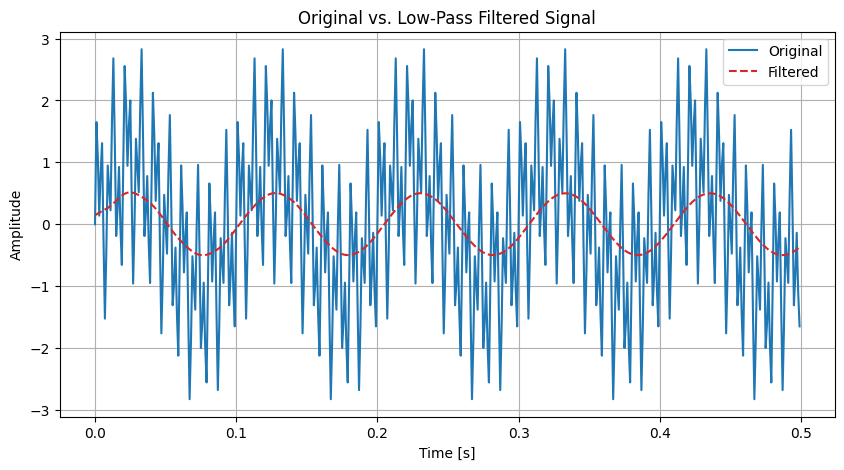

In [23]:
# Frequency vector before shifting
frequencies = np.fft.fftfreq(N, 1/fs)

# Rearranging DFT
X_rearranged = np.concatenate((X_dft[N//2+1:], X_dft[:N//2]))  # Swap halves
f_rearranged = np.concatenate((frequencies[N//2+1:] - fs, frequencies[:N//2]))  # Shift frequencies

# Define Low-pass filter: 1 for |f| ≤ 50 Hz, 0 otherwise
filter_mask = np.abs(f_rearranged) <= 50
Y_rearrange = X_rearranged * filter_mask  # Apply filter in frequency domain

# Rearrange back for inverse DFT
Y = np.concatenate((Y_rearrange[N//2:], Y_rearrange[:N//2+1]))

# Compute inverse DFT
signal_filtered = np.real(iW @ Y) / N

# Plot original vs. filtered signal
plt.figure(figsize=(10, 5))
plt.plot(t[:500], signal_original[:500], label="Original", color='C0')
plt.plot(t[:500], signal_filtered[:500], linestyle="dashed", label="Filtered", color='C3')
plt.title("Original vs. Low-Pass Filtered Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()


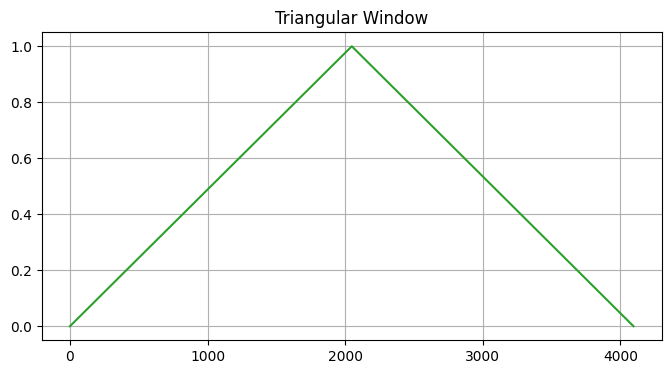

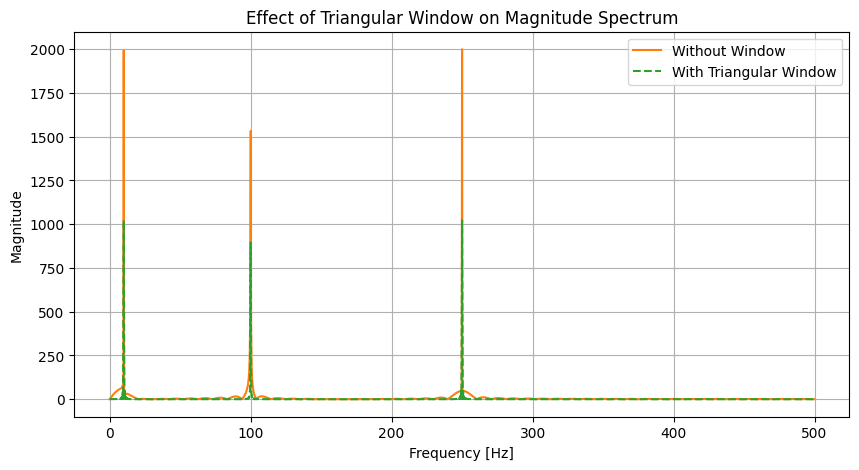

In [24]:
# Apply a triangular window
window1 = sig.windows.triang(N)
Xw1 = W @ (np.multiply(signal_original, window1))  # Compute DFT with window
magnitude_w1 = np.abs(Xw1)

# Plot the triangular window
plt.figure(figsize=(8, 4))
plt.plot(window1, color='C2')
plt.title("Triangular Window")
plt.grid()
plt.show()

# Plot magnitude spectrum with and without window
plt.figure(figsize=(10, 5))
plt.plot(frequencies[:N//2], np.abs(X_dft[:N//2]), label="Without Window", color='C1')
plt.plot(frequencies[:N//2], magnitude_w1[:N//2], label="With Triangular Window", color='C2', linestyle="dashed")
plt.title("Effect of Triangular Window on Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.legend()
plt.grid()
plt.show()
